# Exercício 1

---

In [19]:
# Importando módulos...
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.misc import derivative
from scipy.interpolate import CubicSpline # Interpolação spline

# Lidando com os warnings dos plots
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore')

## Importando dados da questão

---

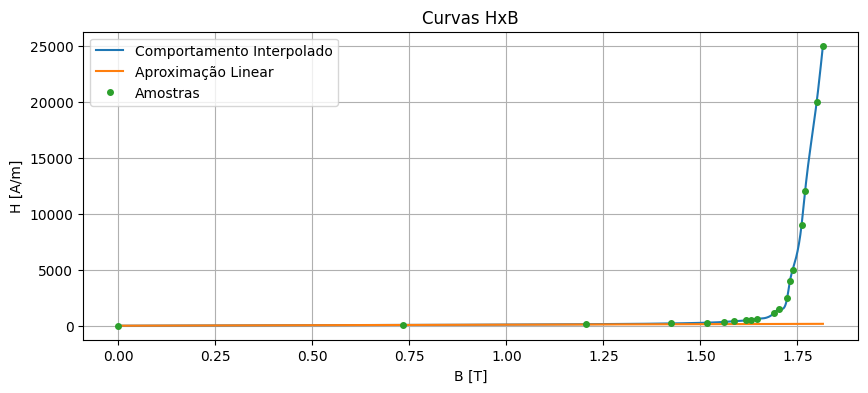

In [20]:
N = 1000 # Número de espiras
g = 2e-3 # Comprimento do entreferro
d = 4e-2 # Largura do núcleo
l = 4e-2 # Profundidade do núcleo
l_c = 70e-2 # Comprimento total do núcleo
A_c = d * l # Área do núcleo
u_0 = np.pi * 4e-7 # Permissividade magnética do ar

# Dados do núcleo (Curva HxB)
H_amostra = np.array([0, 68, 135, 203, 271, 338, 406, 474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
B_amostra = np.array([0, 0.733, 1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703, 1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

# Interpolando dados
H__B_real = CubicSpline(B_amostra, H_amostra, bc_type='natural')

# Extraindo os primeiros dois elementos para forçar um ajuste linear
H__B_linear = CubicSpline(B_amostra[:2], H_amostra[:2], bc_type='natural')

# Idealmente, uma densidade de fluxo gera um campo magnético nulo no condutor, visto que u_c é idealmente infinito 
def H__B_ideal(B): return np.zeros_like(B) 

n_amostras = 1000 # Quantidade de pontos a serem interpolados
B = np.linspace(0, np.max(B_amostra), n_amostras) # Pontos de B igualmente espaçados 

# Gráfico HxB
plt.figure(figsize=(10,4))
plt.title(f'Curvas HxB')
plt.xlabel('B [T]')
plt.ylabel('H [A/m]')
plt.grid(True)

# Plotando dados
plt.plot(B, H__B_real(B), label='Comportamento Interpolado')
plt.plot(B, H__B_linear(B), label='Aproximação Linear')
plt.plot(B_amostra, H_amostra, marker='o', linestyle='None', ms=4, label='Amostras')

plt.legend(loc='best')


## Item 1 e 2

Considerando uma corrente aplicada na bobina de $1$, $5$ e $15$ A, apresente um gráfico para a força magnética que surge no sistema em função do comprimento do entreferro nas condições a seguir:

- O núcleo como sendo ideal;
- Uma aproximação linear da característica do núcleo;
- A característica real do núcleo.

---

In [21]:
# Calcula a força do bloco em função da posição x
def F__x(I_alvo, aprox_H__B, range_x):
    lamb = N * A_c * B # Transformação de densidade de fluxo para fluxo concatenado
    
    # Intervalo de variação de x (remove o último elemento para evitar singularidade)
    intervalo_x = np.linspace(range_x[0], range_x[1], n_amostras+1)[:-1] 
    intervalo_I = np.linspace(0, I_alvo, n_amostras) # Intervalo de variação de I

    # Vetor vazio da coenergia
    W_c = []

    # Repetição para cada posição x
    for x in intervalo_x:
        A_0 = (d - x) * l # Área do entreferro

        # Corrente baseada na Lei de Ampère
        I = (aprox_H__B(B) * l_c + 2 * g * (B * A_c)/(u_0 * A_0))/N 

        # Interpolação dos Fluxos Concatenados
        lamb__I = CubicSpline(I, lamb, bc_type='natural') # Curva λxI

        # Coenergia integrando o fluxo no intervalo de variação de I (0 à I_alvo) para cada valor de x
        W_c.append(sp.integrate.trapezoid(lamb__I(intervalo_I), intervalo_I))

    # Curvas coenergia em função da variação de x
    W_c__x = CubicSpline(intervalo_x, W_c, bc_type='natural')

    # Determinando a força magnética pela derivada da coenergia em relação a x
    F = derivative(W_c__x, intervalo_x, dx=np.max(intervalo_x)/n_amostras)

    # Função de Força x Posição
    F__x = CubicSpline(intervalo_x, F, bc_type='natural')

    return F__x, intervalo_x

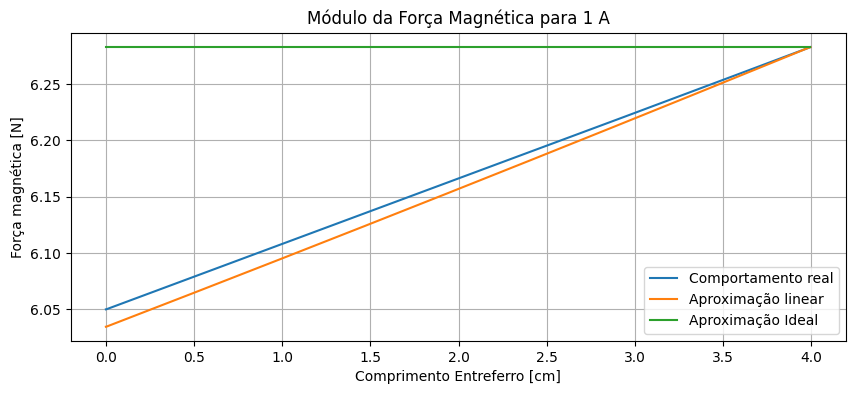

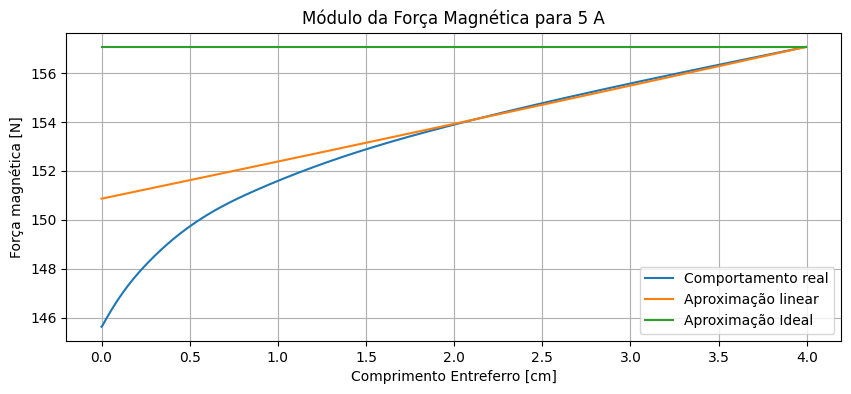

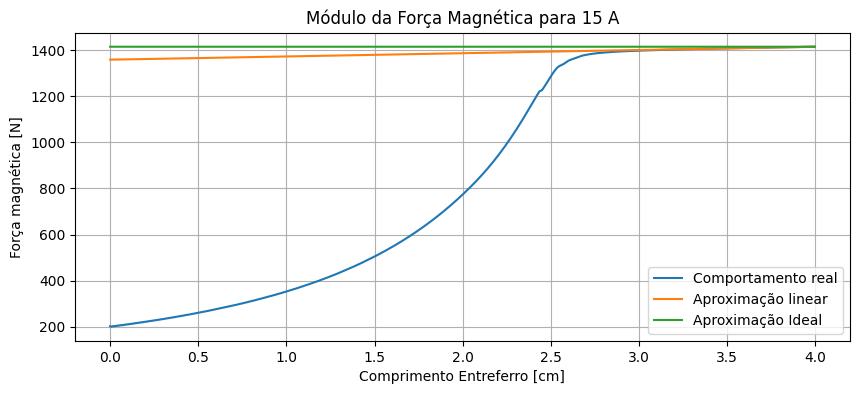

In [22]:
# Para cada corrente exigida
for I_alvo in [1, 5, 15]: # Em ampères
    # Gráficos da força
    plt.figure(figsize=(10,4))
    plt.title(f'Módulo da Força Magnética para {I_alvo} A')
    plt.xlabel('Comprimento Entreferro [cm]')
    plt.ylabel('Força magnética [N]')
    plt.grid()

    # Plotando os gráficos para cada aproximação
    for aprox_H__B, tipo in [[H__B_real, 'Comportamento real'],
                             [H__B_linear, 'Aproximação linear'],
                             [H__B_ideal, 'Aproximação Ideal']]:
        
        aprox_F__x, intervalo_x = F__x(I_alvo, aprox_H__B, [0, d]) # Calculando a curva de força por posição
        plt.plot(intervalo_x * 1e2, np.abs(aprox_F__x(intervalo_x)), label=tipo) # Plotando a curva
    
    plt.legend(loc='best')

## Item 3

Considerando os dados disponíveis, qual seria a maior corrente que poderia ser levar em consideração de modo que se tenha confiabilidade no cálculo da força magnética em função da posição do elemento móvel?

---

In [23]:
# Extraindo os maiores valores amostrados
B_max = np.max(B_amostra)
H_c_max = np.max(H_amostra) 

I_max = (H_c_max * l_c + 2 * g * B_max/u_0)/N # Lei de Ampère

print(f'Corrente Máxima {I_max:.2f} A')

Corrente Máxima 23.28 A


## Item 4

Apresentar um gráfico do tempo necessário para o elemento móvel sair da posição $x=\frac{d}{2}$ até a posição $x=0$ em função da corrente aplicada na bobina. 

O gráfico deve compreender correntes de zero até o valor limite calculado no item anterior.

---

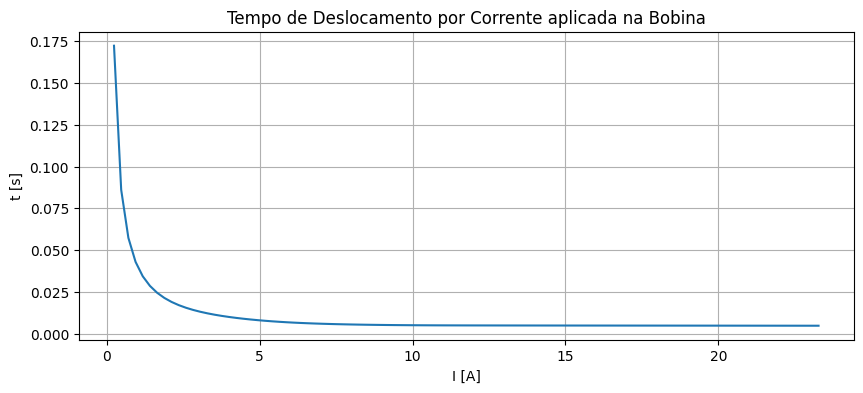

In [24]:
m = 1 # Massa do êmbolo em Kg
intervalo_I = np.linspace(0, I_max, 100)

t__I = []

for I_alvo in intervalo_I: # Em ampères
    F__x_real, intervalo_x = F__x(I_alvo, H__B_real, [0, d/2]) # Calculando a curva de força por posição
    v_real = np.sqrt((2/m)*sp.integrate.trapezoid(np.abs(F__x_real(intervalo_x)), intervalo_x)) # Via energia cinética
    t = (d/2)/v_real
    t__I.append(t)

# Gráfico txI
plt.figure(figsize=(10,4))
plt.title(f'Tempo de Deslocamento por Corrente aplicada na Bobina')
plt.xlabel('I [A]')
plt.ylabel('t [s]')
plt.grid(True)

# Plotando dados
plt.plot(intervalo_I, t__I)
